# Lab exercise 6: The Variational Auto-Encoder
The VAE that we will develop is based on the following generative story:
* $z\sim p(z)$
* $x \sim p(x|z;θ)$

where the latent representations z take value in Rn
. The prior ditribution $p(z)$ is a multivariate Gaussian where each coordinate is independent. We fix the mean and variance of each coordinate to 0 and 1, respectively. The conditional distribution $p(x|z;θ)$ is parameterized by a neural network: it is the decoder! The generated pixels x are independent Gaussians with a fixed variance.

Note: this kind of VAE will be quite bad at generating MNIST picture. Therefore, when you do you experiments, you should both generate picture and display the mean parameters of the output distributions. This is a well known problem of VAE, you can try to play with the network architecture and the parameters to improve generation.

Although the decoder is similar to the auto-encoder decoder, the encoder is different: it must return two tensors, the tensor of means and the tensor of variances. As the variance of a Gaussian distribution is constrained to be strictly positive, it is usual to instead return the log-variance (or log squared variance), which is unconstrained. If you exponentiate the log-variance, you get the variance which will be strictly positive as the exponential function only returns positive values.

Similarly to the auto-encoder, there are several hyperparameters you can try to tune. However, for the VAE I strongly advise you to:
* set the latent space dim to 2
* use [gradient clipping](https://pytorch-org.translate.goog/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html?_x_tr_sl=en&_x_tr_tl=fr&_x_tr_hl=fr&_x_tr_pto=sc) (bound the gradient)


In [ ]:
path = '/content/drive/MyDrive/test/'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import optuna
import os
from sklearn.decomposition import PCA
import matplotlib.cm as cm

In [ ]:
# Ensure directory exists for saving plots
if not os.path.exists(path+'vae_plots'):
    os.makedirs(path+'vae_plots')

In [ ]:
if not os.path.exists(path+'models'):
    os.makedirs(path+'models')

## we did use this version but it didnt worked !
###  for data that has spatial structure, such as images, it is often beneficial to use convolutional layers in the encoder and deconvolutional (or transposed convolutional) layers in the decoder. Convolutional layers take advantage of the spatial structure of the data by applying the same filter across different parts of the input. This allows the model to learn local features (like edges and shapes in images) and achieve translation invariance (the ability to recognize a feature regardless of where it appears in the input).


In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self, channels, dim_latent):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(128*7*7, dim_latent)
        self.fc_logvar = nn.Linear(128*7*7, dim_latent)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class VAEDecoder(nn.Module):
    def __init__(self, dim_latent):
        super().__init__()
        self.fc = nn.Linear(dim_latent, 128*7*7)
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 128, 7, 7)  # Reshape the tensor
        z = F.relu(self.conv2(z))
        z = torch.sigmoid(self.conv1(z))  # Use sigmoid to ensure the output is between 0 and 1
        return z

## the orginal version

In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self, dim_input, dim_latent,dim_hidden,num_hidden_layers=2):
        super().__init__()
        self.dim_latent = dim_latent
        self.dim_input = dim_input
        self.dim_hidden = dim_hidden
        layers = [nn.Linear(dim_input, dim_hidden), nn.ReLU()]
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(dim_hidden, dim_hidden))
            layers.append(nn.ReLU())
        self.hidden_layers = nn.Sequential(*layers)

        self.mu_layer = nn.Linear(dim_hidden, dim_latent)
        self.log_sigma_squared_layer = nn.Linear(dim_hidden, dim_latent)

    def forward(self, inputs):
        # TODO

        # mu = mean
        # log_sigma_squared = log variance
        # The idea is that you use two different output projection:
        # one for the mean, one for the log_sigma_squared
        # but all other layers are shared
        h = self.hidden_layers(inputs)
        mu = self.mu_layer(h)
        log_sigma_squared = self.log_sigma_squared_layer(h)


        return mu, log_sigma_squared

class VAEDecoder(nn.Module):
    def __init__(self, dim_latent, hidden_dim, output_dim,num_hidden_layers=2):
        super().__init__()
        # TODO
        self.dim_latent = dim_latent
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        layers = [nn.Linear(dim_latent, hidden_dim), nn.ReLU()]
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*layers)



    def forward(self, z):
        # TODO

        return self.layers(z)

## report

In this project, we implemented a Variational Autoencoder (VAE) to learn latent representations of image data. The VAE architecture comprises two main components: an encoder and a decoder. This report elaborates on the implementation choices, architectural details, and the reasoning behind selecting specific layers and structures.

Model Architecture
Encoder (VAEEncoder)
The VAEEncoder module transforms the input data into a latent space representation. The architecture is as follows:

Input Dimensions: The encoder accepts input with dimension dim_input.
Latent Space Dimensions: It maps the input to a latent space of dimension dim_latent.
Hidden Layers: The encoder comprises num_hidden_layers hidden layers. The first hidden layer transforms the input to a higher dimensional hidden space dim_hidden using a linear transformation followed by a ReLU activation function to introduce non-linearity. Additional hidden layers further process the data, each consisting of a linear layer followed by ReLU activation. This deep structure enables the network to learn complex patterns from the data.
Output Layers: The final part of the encoder consists of two separate linear layers:
mu_layer: Computes the mean (mu) of the latent Gaussian distribution.
log_sigma_squared_layer: Computes the logarithm of the variance (log_sigma_squared) of the latent Gaussian distribution. These outputs are crucial for the reparameterization trick, enabling efficient backpropagation through stochastic nodes.
Decoder (VAEDecoder)
The VAEDecoder module reconstructs the input data from the latent representations. Its architecture mirrors the encoder in complexity but operates in reverse:

Latent to Hidden: Begins with a linear transformation from the latent dimension dim_latent to a hidden dimension hidden_dim, followed by ReLU activation.
Hidden Layers: Similar to the encoder, the decoder has multiple hidden layers (num_hidden_layers), each consisting of a linear transformation followed by ReLU activation. This setup aids in effectively reconstructing the data from the compressed form.
Output Layer: The final output is passed through a linear layer followed by a Sigmoid activation to scale the output values to the range [0,1], necessary if the original input data is normalized in this range.
Choice of Implementation
Given that the input data is images, the current implementation using fully connected layers may not be the most optimal. Convolutional layers are particularly effective for image data as they can capture spatial information and hierarchical patterns in the data, which can lead to better performance.

The current implementation was chosen for its simplicity and ease of understanding. Fully connected networks are simpler to implement and modify, and they are well-suited for smaller datasets or less complex data distributions. However, for image data, a more suitable choice could be a Convolutional Variational Autoencoder (CVAE), which uses convolutional layers in the encoder and deconvolutional (or transposed convolutional) layers in the decoder.



In [ ]:
def load_decoder(latent_dim, hidden_dim, output_dim, num_layers, model_file):
    decoder = VAEDecoder(dim_latent=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_hidden_layers=num_layers)
    decoder.load_state_dict(torch.load(model_file))
    decoder.eval()  # Set the model to evaluation mode
    return decoder

def load_encoder(dim_input, dim_latent, hidden_dim, num_layers, model_file):
    encoder = VAEEncoder(dim_input=dim_input, dim_latent=dim_latent, dim_hidden=hidden_dim, num_hidden_layers=num_layers)
    encoder.load_state_dict(torch.load(model_file))
    encoder.eval()  # Set the model to evaluation mode
    return encoder


### Function Descriptions
load_decoder
load_decoder sets up and loads a pre-trained decoder part of a VAE, which rebuilds the original data from the latent space. It takes parameters for the size of the latent space, hidden layers, input data, number of hidden layers, and the filepath to the pre-trained model weights. It then creates the decoder, loads the pre-trained weights, and sets the model to evaluation mode for consistent performance.

load_encoder
load_encoder is similar to load_decoder, but for the encoder part of a VAE, which transforms the input data into a compressed latent representation. It takes similar parameters to load_decoder, creates the encoder, loads its pre-trained weights, and switches to evaluation mode.

Implementation Choices
The current implementation uses fully connected layers for simplicity. However, for tasks involving spatial data, convolutional layers (in the encoder) and deconvolutional layers (in the decoder) might be more effective. PyTorch supports these advanced layers, which can be added to the VAEEncoder and VAEDecoder classes to handle complex, high-dimensional data.

Conclusion
load_decoder and load_encoder are essential for efficient VAE deployment, allowing us to reuse pre-trained models and save computational resources.

In [ ]:


def plot_latent_space_pca(encoder, dataset, batch_size=128):
    dl = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    az = []
    ay = []
    with torch.no_grad():
        for x, y in dl:
            mu, _ = encoder(x)  # Only use mu for PCA
            az.extend(mu.tolist())
            ay.extend(y.tolist())
    az = np.array(az)
    ay = np.array(ay)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(az)

    colors = cm.rainbow(np.linspace(0, 1, 10))
    plt.figure(figsize=(8, 6))
    for i in range(10):
        plt.scatter(pca_result[ay == i][:, 0], pca_result[ay == i][:, 1], color=colors[i], label=f'Class {i}', alpha=0.5)
    plt.title('PCA of Latent Space')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend()
    plt.grid(True)
    plt.show()


## Implementation Choices
The implementation uses PyTorch for model operations and sklearn for PCA. It visualizes only the mu component, focusing on the central tendency of the latent representations.

Discussion
For models handling image data, using convolutional layers in the encoder can better capture spatial hierarchies. If the VAE uses convolutional networks, adjustments might be needed in data preparation for PCA.

Conclusion
The plot_latent_space_pca function is a practical tool for visualizing a VAE's effectiveness in encoding its input data into a meaningful latent space. As VAE architectures evolve, especially with convolutional approaches for complex datasets like images, enhancements in visualization techniques will be crucial for comprehensive model evaluation.

In [ ]:
def plot_generated_images(decoder, n=10, latent_dim=2):
    z = torch.randn((n * n, latent_dim))  # sampling z from a standard normal distribution
    with torch.no_grad():
        generated = decoder(z)
    imgs = np.zeros((n*28, n*28))
    plt.figure(figsize=(10, 10))
    for i in range(n*n):
        imgs[i//n * 28: i//n * 28 + 28, i%n * 28: i%n * 28 + 28] = 1 - generated[i].view(28, 28).cpu().numpy()
    plt.axis('off')
    plt.imshow(imgs, cmap='Greys')
    plt.show()

## Purpose
The plot_generated_images function visualizes images generated by a Variational Autoencoder's (VAE) decoder from latent space representations, assessing the model's output diversity and quality.

Description
Parameters: decoder (trained VAE decoder), n (number of images per axis, default: 10), latent_dim (latent space dimensionality, default: 2).

Process:

Generates n^2 samples from a standard normal distribution, each a point in the latent space.
Decodes each latent sample into an image under the torch.no_grad() context for performance.
Reshapes each output into a 28x28 image and inverts its colors for visibility.
Combines all images into a single array and displays using matplotlib, each 28x28 block representing a unique generated image.
Utility
This visualization helps understand the latent space structure and the decoder's effectiveness. If the VAE is well-trained, similar images should be produced from nearby points in the latent space.

Usage
Useful in debugging and presenting VAE training results. Observing the generated images provides insights into how latent space changes affect outputs, aiding in model architecture or training regimen improvements.

To compute the training loss, you must compute two terms:
* A Monte-Carlo estimation of the reconstruction loss (you can start considering sampling only one z)
* The KL divergence between the distributions computed by the encoder and the prior

For the reconstruction loss, you can use the mean square error loss.

To sample values, you can use the reparameterization trick as follows:
```
e = torch.normal(0, 1., mu.shape)
z = mu + e * torch.sqrt(torch.exp(log_sigma_squared))
```

For the formula of the $KL(q(z|x)|| p(z))$ you should have it from the exercise we did during the lecture. You can also check appendix of the [original paper](https://arxiv.org/pdf/1312.6114.pdf)

You have in the following to implements:
* The training loop
* The two losses
* Choose which architecture for encoder and decoder

In [ ]:
def KL(mu,log_sigma):
    #TODO
    return -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp())

def reconstruction_loss(input_image, predicted_image):
    #TODO
    return torch.nn.functional.mse_loss(predicted_image, input_image, reduction='sum')
    #return torch.nn.functional.binary_cross_entropy(predicted_image, input_image, reduction='sum')

def training_loop(dataset, encoder, decoder, model_name,n_sample_monte_carlo=1, max_epoch=50, learning_rate=1e-3, batch_size=128, max_grad_norm=5e-1,plot=True,verbose=True):
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
    epoch_losses = []  # Store average loss per epoch for plotting
    # Save the model with the best loss
    best_loss = float('inf')
    save_encoder = f"{path}models/encoder_{model_name}.pth"
    save_decoder =  f"{path}models/decoder_{model_name}.pth"



    for epoch in range(max_epoch):
        losses = []  # Store losses for current epoch
        total_loss =0
        for x in data_loader:  # Assuming dataset only contains features and no labels
            optimizer.zero_grad()
            mu, log_sigma = encoder(x)
            # Sampling using the reparameterization trick
            e = torch.normal(0, 1., mu.shape)
            z = mu + e * torch.exp(0.5 * log_sigma)
            y = decoder(z)

            loss = reconstruction_loss(x, y) + KL(mu, log_sigma)
            losses.append(loss.item())

            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), max_grad_norm)
            optimizer.step()
            total_loss += loss.item()
            if torch.isnan(loss):
              print(f"NaN detected at epoch {epoch+1} with parameters: lr={learning_rate}, max_grad_norm={max_grad_norm}, etc.")
              break

        avg_loss = total_loss / len(dataset)
        epoch_losses.append(avg_loss)  # Record the average loss for the epoch

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(encoder.state_dict(), save_encoder)
            torch.save(decoder.state_dict(), save_decoder)
            print(f"Updated best model with loss: {avg_loss}")

        if verbose:
          print(f"Epoch {epoch+1}/{max_epoch}, Average Loss: {avg_loss}")

    if plot:
      # After training, plot the losses
      plt.figure(figsize=(10, 5))
      plt.plot(epoch_losses, label='Loss per Epoch')
      plt.title('Training Loss Per Epoch')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.grid(True)
      plt.show()
    return sum(epoch_losses) / len(epoch_losses)




### Training and Loss Function Implementation for Variational Autoencoder
Introduction
This report outlines the implementation details of the training loop and associated loss functions for a Variational Autoencoder (VAE) developed using PyTorch. The VAE is designed to encode input data into a compressed latent space and then reconstruct the input from this space, facilitating data generation and anomaly detection among other applications.

Implementation Details
Architectural Choice
Traditional VAE: The current implementation uses fully connected layers for both the encoder and decoder. This architecture is straightforward and effective for datasets with low-dimensional input spaces or less spatial complexity.
Convolutional VAE: For datasets with high-dimensional inputs like images, convolutional networks (ConvNets) for the encoder and corresponding deconvolutional networks for the decoder are recommended. ConvNets help capture spatial hierarchies in data, enhancing the model's ability to learn pertinent features effectively.
Loss Functions
KL Divergence: The Kullback-Leibler divergence, calculated in the KL function, measures how one probability distribution diverges from a second, expected distribution. Here, it quantifies the difference between the encoded distribution and a standard normal distribution, acting as a regularizer in the training process.



### Kullback-Leibler (KL) Divergence: This loss measures how much the latent distribution deviates from a standard normal distribution. The formula for KL divergence between a normal distribution with mean mu and standard deviation sigma and a standard normal distribution is:

In [ ]:
def KL(mu, log_sigma):
    return -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp())


# KL = 0.5 * Σ (1 + log_sigma - mu^2 - exp(log_sigma))

##### Reconstruction Loss: Implemented using mean squared error (MSE), this loss function measures the pixel-wise differences between the original input and its reconstruction, focusing the model on accurately reproducing inputs.


In [ ]:
def reconstruction_loss(input_image, predicted_image):
    return torch.nn.functional.mse_loss(predicted_image, input_image, reduction='sum')


### Reconstruction Loss: This loss measures how well the decoder is able to reconstruct the original input from the latent representation. In your code, you're using the Mean Squared Error (MSE) loss for this purpose. The formula for MSE loss is:

# MSE = 1/n * Σ (x_i - y_i)^2

### where x_i is the original input, y_i is the reconstructed input, and n is the number of elements in x_i or y_i.

### Training Loop
Setup: The training loop iterates over the dataset in batches, using the Adam optimizer for updating model parameters based on the computed gradients.
Reparameterization Trick: To enable gradient descent through the random sampling process, the reparameterization trick is applied:

In [ ]:
e = torch.normal(0, 1., mu.shape)
z = mu + e * torch.exp(0.5 * log_sigma)


### Gradient Management: Gradients are calculated for both loss terms and backpropagated through the network. Gradient clipping is employed to prevent exploding gradients. Visualization: If enabled, training loss per epoch is plotted to visually track the learning progress.

In [ ]:
import dataset_loader # file given in lab 3
# Download mnist dataset
if("mnist.pkl.gz" not in os.listdir(path)):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    !wget https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = path+"mnist.pkl.gz"


train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

dataset = train_data[0] # we are not interrested having labels






Updated best model with loss: 54.697279609375
Epoch 1/50, Average Loss: 54.697279609375
Updated best model with loss: 43.41982224609375
Epoch 2/50, Average Loss: 43.41982224609375
Updated best model with loss: 41.4316034765625
Epoch 3/50, Average Loss: 41.4316034765625
Updated best model with loss: 40.37095587890625
Epoch 4/50, Average Loss: 40.37095587890625
Updated best model with loss: 39.6407206640625
Epoch 5/50, Average Loss: 39.6407206640625
Updated best model with loss: 39.1058517578125
Epoch 6/50, Average Loss: 39.1058517578125
Updated best model with loss: 38.69360869140625
Epoch 7/50, Average Loss: 38.69360869140625
Updated best model with loss: 38.3437666015625
Epoch 8/50, Average Loss: 38.3437666015625
Updated best model with loss: 38.09538119140625
Epoch 9/50, Average Loss: 38.09538119140625
Updated best model with loss: 37.81203125
Epoch 10/50, Average Loss: 37.81203125
Updated best model with loss: 37.56824505859375
Epoch 11/50, Average Loss: 37.56824505859375
Updated be

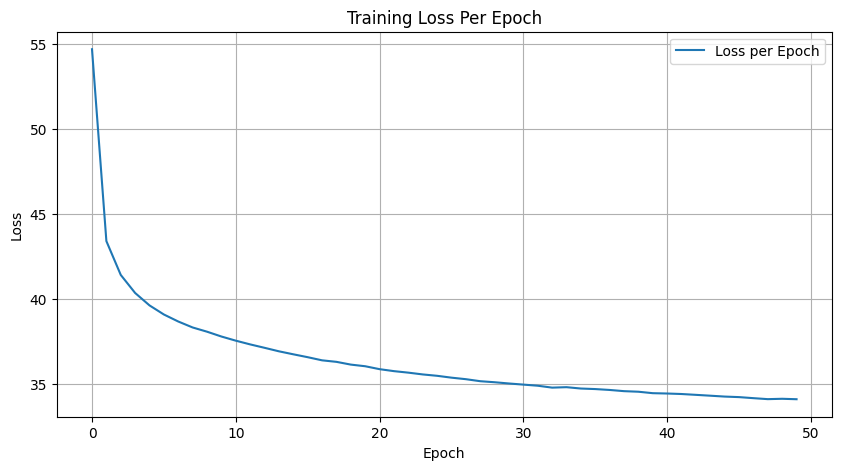

36.47109080449218

In [ ]:
# Parameters for the VAE
dim_hidden = 256
num_hidden_layers = 2

# Create the encoder and decoder
encoder = VAEEncoder(dim_input=784, dim_latent=2, dim_hidden=dim_hidden, num_hidden_layers=num_hidden_layers)
decoder = VAEDecoder(dim_latent=2, hidden_dim=dim_hidden, output_dim=784, num_hidden_layers=num_hidden_layers)

# Parameters for training
learning_rate = 1e-3
batch_size = 256
max_epochs = 50


# Call the training function
training_loop(dataset, encoder, decoder,f'lr=1e-3,bs=256,max_epochs=50', max_epoch=max_epochs, learning_rate=learning_rate, batch_size=batch_size)

## the training of a Variational Autoencoder (VAE) using fully connected layers for both the encoder and decoder. Two loss functions, KL Divergence and Reconstruction Loss, are used to measure the performance of the model. The training was conducted over 50 epochs with a learning rate of 0.001 and a batch size of 256. The training loss graph shows a sharp decline in the initial epochs, indicating that the model quickly learned the underlying data structure. The loss then gradually decreased, suggesting ongoing model refinement. The report concludes that while the training process was effective, further improvements might require adjustments in the network architecture or hyperparameters.

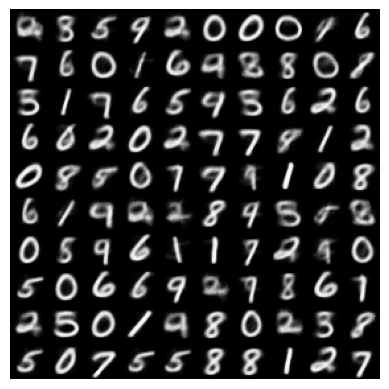

In [ ]:
n = 10
# get best_lattent_dim from the best trial
latent_dim = 2
z = torch.randn((n * n, latent_dim))  # sampling z from a standard normal distribution
decoder_path = path+"models/decoder_lr=1e-3,bs=256,max_epochs=50.pth"
decoder = load_decoder(latent_dim=2, hidden_dim=256, output_dim=784, num_layers=2, model_file=decoder_path)
generated = decoder(z)
imgs = np.zeros((n*28, n*28))

plt.figure()
for i in range(n*n):
    imgs[i//n  * 28: i//n * 28 + 28,i%n * 28 : i%n * 28 + 28] = 1 - generated[i].detach().numpy().reshape(28,28)
plt.axis('off')
plt.imshow(imgs, cmap='Greys')

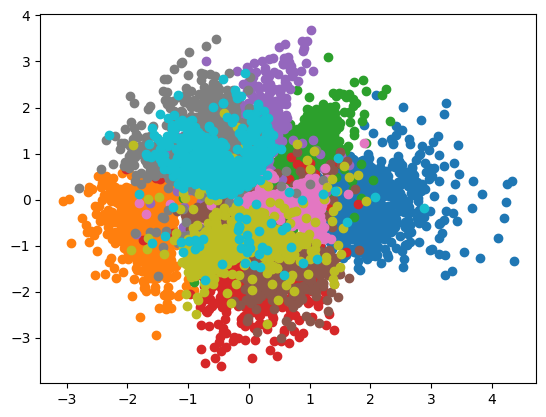

In [ ]:
import matplotlib.cm as cm

labels = np.array(dev_data[1])
images = np.array(dev_data[0])

encoder_path = path+"models/encoder_lr=1e-3,bs=256,max_epochs=50.pth"
encoder = load_encoder(dim_input=784, dim_latent=2, hidden_dim=256, num_layers=2, model_file=encoder_path)
dl = DataLoader(list(zip(images, labels)), batch_size=128, shuffle=True, drop_last=True)
az = []
ay = []
with torch.no_grad():
    for x, y in dl:
        mu, log_sigma = encoder(x)

        z = torch.randn(mu.shape) * torch.exp(0.5 * log_sigma) + mu
        az += z.tolist()
        ay += y.tolist()
az = np.array(az)
ay = np.array(ay)

colors = cm.rainbow(np.linspace(0, 1, 10))
for i in range(10):
    plt.scatter(az[ay == i][:, 0], az[ay == i][:, 1])

We try another model with different batch size

Updated best model with loss: 49.50592491210938
Epoch 1/50, Average Loss: 49.50592491210938
Updated best model with loss: 41.36119174804688
Epoch 2/50, Average Loss: 41.36119174804688
Updated best model with loss: 39.82340594726563
Epoch 3/50, Average Loss: 39.82340594726563
Updated best model with loss: 38.87027583984375
Epoch 4/50, Average Loss: 38.87027583984375
Updated best model with loss: 38.1930741796875
Epoch 5/50, Average Loss: 38.1930741796875
Updated best model with loss: 37.70232758789062
Epoch 6/50, Average Loss: 37.70232758789062
Updated best model with loss: 37.30325163085938
Epoch 7/50, Average Loss: 37.30325163085938
Updated best model with loss: 36.9981402734375
Epoch 8/50, Average Loss: 36.9981402734375
Updated best model with loss: 36.73703752929688
Epoch 9/50, Average Loss: 36.73703752929688
Updated best model with loss: 36.469585830078124
Epoch 10/50, Average Loss: 36.469585830078124
Updated best model with loss: 36.229104716796876
Epoch 11/50, Average Loss: 36.22

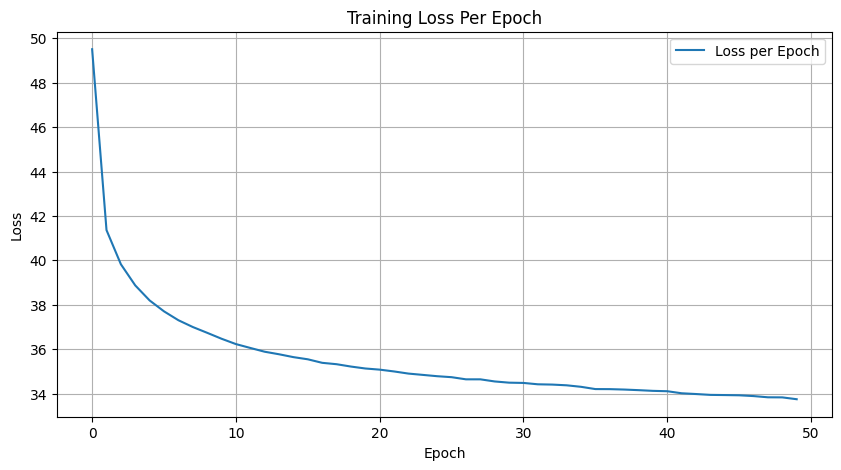

35.576984762109376

In [ ]:
# Parameters for the VAE
dim_hidden = 256
num_hidden_layers = 2

# Create the encoder and decoder
encoder = VAEEncoder(dim_input=784, dim_latent=2, dim_hidden=dim_hidden, num_hidden_layers=num_hidden_layers)
decoder = VAEDecoder(dim_latent=2, hidden_dim=dim_hidden, output_dim=784, num_hidden_layers=num_hidden_layers)

# Parameters for training
learning_rate = 1e-3
batch_size = 128
max_epochs = 50


# Call the training function
training_loop(dataset, encoder, decoder,f'lr=1e-3,bs=128,max_epochs=50', max_epoch=max_epochs, learning_rate=learning_rate, batch_size=batch_size)

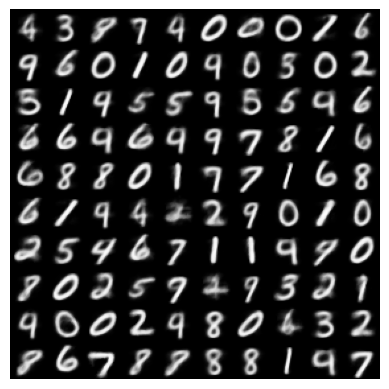

In [ ]:
decoder_path = path+"models/decoder_lr=1e-3,bs=128,max_epochs=50.pth"
decoder2 = load_decoder(latent_dim=2, hidden_dim=256, output_dim=784, num_layers=2, model_file=decoder_path)
generated = decoder(z)
imgs = np.zeros((n*28, n*28))

plt.figure()
for i in range(n*n):
    imgs[i//n  * 28: i//n * 28 + 28,i%n * 28 : i%n * 28 + 28] = 1 - generated[i].detach().numpy().reshape(28,28)
plt.axis('off')
plt.imshow(imgs, cmap='Greys')

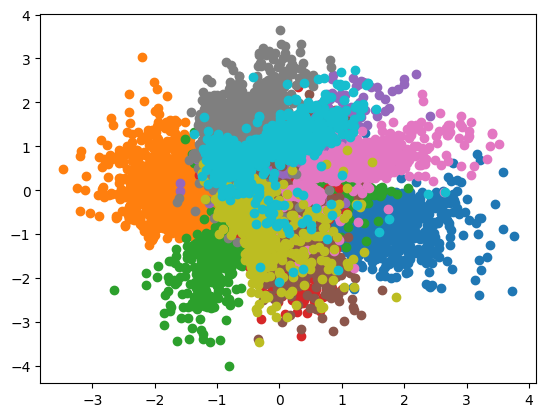

In [ ]:
import matplotlib.cm as cm

labels = np.array(dev_data[1])
images = np.array(dev_data[0])
az = []
ay = []
encoder_path = path+"models/encoder_lr=1e-3,bs=128,max_epochs=50.pth"
encoder = load_encoder(dim_input=784, dim_latent=2, hidden_dim=256, num_layers=2, model_file=encoder_path)
with torch.no_grad():
    for x, y in dl:
        mu, log_sigma = encoder(x)

        z = torch.randn(mu.shape) * torch.exp(0.5 * log_sigma) + mu
        az += z.tolist()
        ay += y.tolist()
az = np.array(az)
ay = np.array(ay)

colors = cm.rainbow(np.linspace(0, 1, 10))
for i in range(10):
    plt.scatter(az[ay == i][:, 0], az[ay == i][:, 1])

# Optimizing hyperparameters

In [ ]:
def training_loop_with_plots(dataset, encoder, decoder, n_sample_monte_carlo=1, max_epoch=50, learning_rate=1e-3, batch_size=128, max_grad_norm=5e-1):
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
    epoch_losses = []  # Store average loss per epoch for plotting

    for epoch in range(max_epoch):
        total_loss = 0
        for x in data_loader:  # Assuming dataset only contains features and no labels
            optimizer.zero_grad()
            mu, log_sigma = encoder(x)
            e = torch.normal(0, 1., mu.shape)
            z = mu + e * torch.exp(0.5 * log_sigma)
            y = decoder(z)
            loss = reconstruction_loss(x, y) + KL(mu, log_sigma)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), max_grad_norm)
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataset)
        epoch_losses.append(avg_loss)  # Record the average loss for the epoch
    return epoch_losses

In [ ]:
# Hyperparameters to tune
learning_rates = [1e-3, 1e-4]
max_grad_norms = [0.1, 0.5]
num_hidden_layers_options = [2, 3]

def run_grid_search():
    results = {}
    plt.figure(figsize=(14, 8))

    for lr in learning_rates:
        for max_grad in max_grad_norms:
            for num_layers in num_hidden_layers_options:
                encoder = VAEEncoder(dim_input=784, dim_latent=2, dim_hidden=256, num_hidden_layers=num_layers)
                decoder = VAEDecoder(dim_latent=2, hidden_dim=256, output_dim=784, num_hidden_layers=num_layers)
                print(f"Training with lr={lr}, max_grad_norm={max_grad}, num_hidden_layers={num_layers}")
                losses = training_loop_with_plots(
                    dataset=dataset,
                    encoder=encoder,
                    decoder=decoder,
                    max_epoch=50,
                    learning_rate=lr,
                    batch_size=256,
                    max_grad_norm=max_grad
                )
                results[(lr, max_grad, num_layers)] = losses
                print(f"Average Loss: {sum(losses)/len(losses)}")
                # Plot and save individual loss curve
                plt.plot(losses, label=f'LR: {lr}, MaxGrad: {max_grad}, Layers: {num_layers}')
                plt.title(f'Training Loss Per Epoch\nLR: {lr}, MaxGrad: {max_grad}, Layers: {num_layers}')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True)
                plt.savefig(f'{path}vae_plots/loss_lr{lr}_maxgrad{max_grad}_layers{num_layers}.png')
                plt.clf()

    # Generate combined plot
    for key, value in results.items():
        plt.plot(value, label=f'LR: {key[0]}, MaxGrad: {key[1]}, Layers: {key[2]}')

    plt.title('Comparison of Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(path+'vae_plots/combined_loss.png')
    plt.show()

    return results



Training with lr=0.001, max_grad_norm=0.1, num_hidden_layers=2
Average Loss: 36.34451233925782
Training with lr=0.001, max_grad_norm=0.1, num_hidden_layers=3
Average Loss: 36.197842489062495
Training with lr=0.001, max_grad_norm=0.5, num_hidden_layers=2
Average Loss: 36.3795583453125
Training with lr=0.001, max_grad_norm=0.5, num_hidden_layers=3
Average Loss: 36.49142336347655
Training with lr=0.0001, max_grad_norm=0.1, num_hidden_layers=2
Average Loss: 41.441198447656255
Training with lr=0.0001, max_grad_norm=0.1, num_hidden_layers=3
Average Loss: 40.807754147656254
Training with lr=0.0001, max_grad_norm=0.5, num_hidden_layers=2
Average Loss: 41.45522099570313
Training with lr=0.0001, max_grad_norm=0.5, num_hidden_layers=3
Average Loss: 40.822532421874996


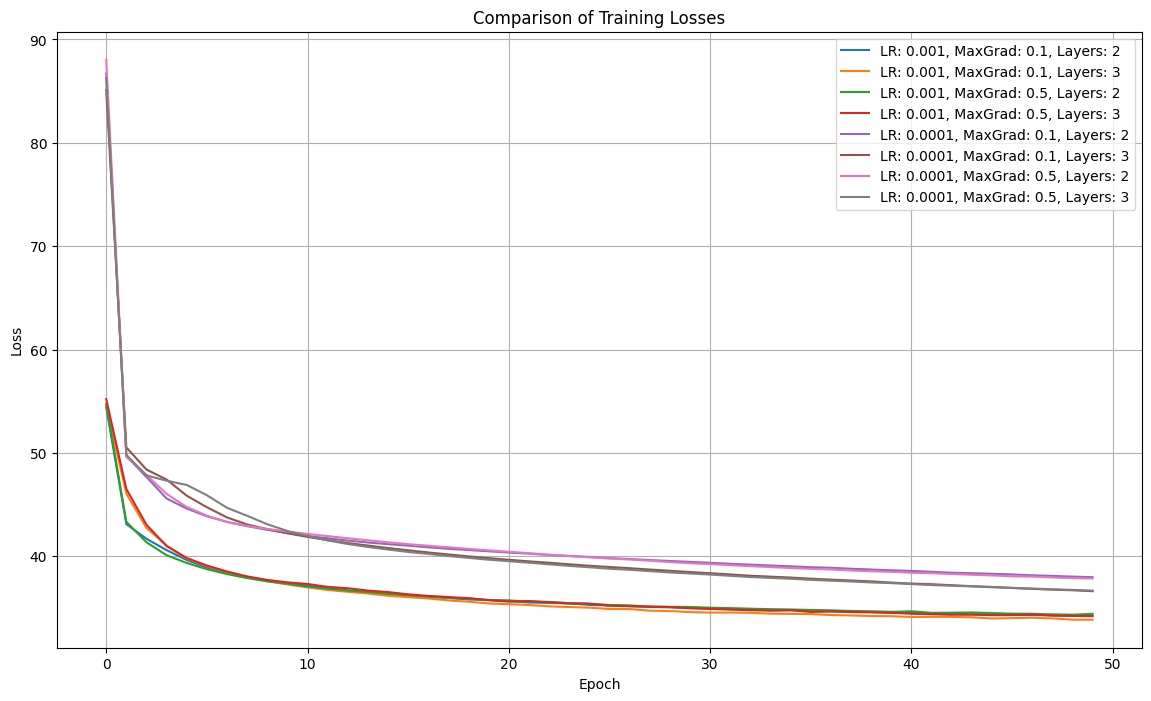

In [ ]:
# Run the grid search
grid_search_results = run_grid_search()


In [ ]:
# Print results
for params, loss in grid_search_results.items():
    print(f"Params: lr={params[0]}, max_grad_norm={params[1]}, num_layers={params[2]} - Loss: {loss}")


Params: lr=0.001, max_grad_norm=0.1, num_layers=2 - Loss: [54.419130546875, 43.10674578125, 41.68748462890625, 40.595771328125, 39.6347161328125, 38.9092286328125, 38.3808744140625, 37.99133685546875, 37.656805, 37.38273751953125, 37.15984365234375, 36.91196767578125, 36.6932141796875, 36.52961232421875, 36.35374072265625, 36.20299720703125, 36.09440951171875, 35.95970203125, 35.8193096875, 35.74987142578125, 35.66348720703125, 35.524977109375, 35.489430859375, 35.4401803515625, 35.29305021484375, 35.2386317578125, 35.18746248046875, 35.09907666015625, 35.05093982421875, 35.00903849609375, 34.9653502734375, 34.88483220703125, 34.8529217578125, 34.7891109375, 34.77500861328125, 34.71274240234375, 34.685516484375, 34.60694658203125, 34.60097658203125, 34.5507634765625, 34.5238195703125, 34.48254525390625, 34.43016591796875, 34.392686025390624, 34.355305, 34.32155646484375, 34.30964126953125, 34.2839284765625, 34.235638359375, 34.23038708984375]
Params: lr=0.001, max_grad_norm=0.1, num_la

In [ ]:
best_params, best_loss = min(grid_search_results.items(), key=lambda x: x[1][-1])
print(f"Best Parameters: lr={best_params[0]}, max_grad_norm={best_params[1]}, num_layers={best_params[2]} - Best Loss: {best_loss[-1]}")

Best Parameters: lr=0.001, max_grad_norm=0.1, num_layers=3 - Best Loss: 33.85924787109375


# -----------------------------------------------------

# Some experiments but nothing concluant

In [ ]:
""" def bayesian_optimization(func, bounds, num_iter, initial_data, initial_y):
    # Initialize the surrogate probabilistic model
    model = GaussianProcess()

    # Seed with initial data
    X = initial_data
    Y = initial_y
    model.fit(X, Y)

    for i in range(num_iter):
        # Find the next set of hyperparams to evaluate (acquisition function)
        next_x = find_next_sample(model, bounds)

        # Evaluate the objective function
        next_y = func(next_x)

        # Update the model
        X.append(next_x)
        Y.append(next_y)
        model.update(X, Y)

    best_params = X[np.argmin(Y)]
    return best_params
 """

' def bayesian_optimization(func, bounds, num_iter, initial_data, initial_y):\n    # Initialize the surrogate probabilistic model\n    model = GaussianProcess()\n\n    # Seed with initial data\n    X = initial_data\n    Y = initial_y\n    model.fit(X, Y)\n\n    for i in range(num_iter):\n        # Find the next set of hyperparams to evaluate (acquisition function)\n        next_x = find_next_sample(model, bounds)\n\n        # Evaluate the objective function\n        next_y = func(next_x)\n\n        # Update the model\n        X.append(next_x)\n        Y.append(next_y)\n        model.update(X, Y)\n\n    best_params = X[np.argmin(Y)]\n    return best_params\n '

In [ ]:
''' def objective(trial):
    # Fixed dimensions based on the dataset
    dim_input = 784
    dim_output = 784

    # Define hyperparameters to optimize
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3)
    dim_hidden = trial.suggest_categorical('dim_hidden', [128, 256, 512])
    max_grad_norm = trial.suggest_float('max_grad_norm', 0.1, 1.0)
    dim_latent = trial.suggest_int('dim_latent', 2, 15)

    print
    # Model setup
    encoder = VAEEncoder(dim_input, dim_latent, dim_hidden, num_hidden_layers)
    decoder = VAEDecoder(dim_latent, dim_hidden, dim_output, num_hidden_layers)

    # Data loading
    train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

    # Use the modified training loop
    #    def training_loop(dataset, encoder, decoder, n_sample_monte_carlo=1, max_epoch=50, learning_rate=1e-3, batch_size=128, max_grad_norm=5e-1,plot=True):

    average_loss = training_loop(dataset = dataset, encoder = encoder,decoder =  decoder, n_sample_monte_carlo = 1,max_epoch=50, learning_rate=1,batch_size=128, max_grad_norm=max_grad_norm,plot = False)


    # Save the plot for the trial
    plot_path = path+ (f"trial_{trial.number}_loss_plot.png")
    plt.figure(figsize=(8, 4))
    plt.plot(average_loss, label=f'Trial {trial.number + 1}')
    plt.title(f"Loss per Epoch for Trial {trial.number + 1}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(plot_path)
    plt.close()

    return average_loss

 '''

In [ ]:
''' # Create and run the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10) '''

[I 2024-05-02 11:59:20,238] A new study created in memory with name: no-name-5639fe17-29d3-4ab9-8036-f4732f40f3b6


Epoch 1/50, Average Loss: 2.80185241872001e+25
Epoch 2/50, Average Loss: 88.150093671875
Epoch 3/50, Average Loss: 88.1595290234375
Epoch 4/50, Average Loss: 88.12563115234374
Epoch 5/50, Average Loss: 88.135644453125
Epoch 6/50, Average Loss: 88.14741126953125
Epoch 7/50, Average Loss: 88.13054298828125
Epoch 8/50, Average Loss: 88.09762017578124
Epoch 9/50, Average Loss: 88.09240541015625
Epoch 10/50, Average Loss: 88.11574982421875
Epoch 11/50, Average Loss: 88.10405796875
Epoch 12/50, Average Loss: 88.0946342578125
Epoch 13/50, Average Loss: 88.100668515625
Epoch 14/50, Average Loss: 88.1004616796875
Epoch 15/50, Average Loss: 88.10991158203124
Epoch 16/50, Average Loss: 88.0886235546875
Epoch 17/50, Average Loss: 88.10620193359375
Epoch 18/50, Average Loss: 88.095021484375
Epoch 19/50, Average Loss: 88.11746890625
Epoch 20/50, Average Loss: 88.098444140625
Epoch 21/50, Average Loss: 88.10556806640625
Epoch 22/50, Average Loss: 88.09153958984375
Epoch 23/50, Average Loss: 88.100449

[I 2024-05-02 12:07:25,303] Trial 0 finished with value: 5.6037048374400203e+23 and parameters: {'lr': 0.000264706324738412, 'num_hidden_layers': 1, 'dim_hidden': 256, 'max_grad_norm': 0.36781837094339664, 'dim_latent': 5}. Best is trial 0 with value: 5.6037048374400203e+23.


NaN detected at epoch 1 with parameters: lr=1, max_grad_norm=0.7735850992198071, etc.
Epoch 1/50, Average Loss: nan
NaN detected at epoch 2 with parameters: lr=1, max_grad_norm=0.7735850992198071, etc.
Epoch 2/50, Average Loss: nan
NaN detected at epoch 3 with parameters: lr=1, max_grad_norm=0.7735850992198071, etc.
Epoch 3/50, Average Loss: nan
NaN detected at epoch 4 with parameters: lr=1, max_grad_norm=0.7735850992198071, etc.
Epoch 4/50, Average Loss: nan
NaN detected at epoch 5 with parameters: lr=1, max_grad_norm=0.7735850992198071, etc.
Epoch 5/50, Average Loss: nan
NaN detected at epoch 6 with parameters: lr=1, max_grad_norm=0.7735850992198071, etc.
Epoch 6/50, Average Loss: nan
NaN detected at epoch 7 with parameters: lr=1, max_grad_norm=0.7735850992198071, etc.
Epoch 7/50, Average Loss: nan
NaN detected at epoch 8 with parameters: lr=1, max_grad_norm=0.7735850992198071, etc.
Epoch 8/50, Average Loss: nan
NaN detected at epoch 9 with parameters: lr=1, max_grad_norm=0.773585099

[W 2024-05-02 12:07:27,895] Trial 1 failed with parameters: {'lr': 0.0068915599361614515, 'num_hidden_layers': 2, 'dim_hidden': 512, 'max_grad_norm': 0.7735850992198071, 'dim_latent': 6} because of the following error: The value nan is not acceptable.
[W 2024-05-02 12:07:27,897] Trial 1 failed with value nan.


NaN detected at epoch 1 with parameters: lr=1, max_grad_norm=0.1879564609009269, etc.
Epoch 1/50, Average Loss: nan
NaN detected at epoch 2 with parameters: lr=1, max_grad_norm=0.1879564609009269, etc.
Epoch 2/50, Average Loss: nan
NaN detected at epoch 3 with parameters: lr=1, max_grad_norm=0.1879564609009269, etc.
Epoch 3/50, Average Loss: nan
NaN detected at epoch 4 with parameters: lr=1, max_grad_norm=0.1879564609009269, etc.
Epoch 4/50, Average Loss: nan
NaN detected at epoch 5 with parameters: lr=1, max_grad_norm=0.1879564609009269, etc.
Epoch 5/50, Average Loss: nan
NaN detected at epoch 6 with parameters: lr=1, max_grad_norm=0.1879564609009269, etc.
Epoch 6/50, Average Loss: nan
NaN detected at epoch 7 with parameters: lr=1, max_grad_norm=0.1879564609009269, etc.
Epoch 7/50, Average Loss: nan
NaN detected at epoch 8 with parameters: lr=1, max_grad_norm=0.1879564609009269, etc.
Epoch 8/50, Average Loss: nan
NaN detected at epoch 9 with parameters: lr=1, max_grad_norm=0.187956460

[W 2024-05-02 12:07:30,334] Trial 2 failed with parameters: {'lr': 0.0022935760936132906, 'num_hidden_layers': 2, 'dim_hidden': 512, 'max_grad_norm': 0.1879564609009269, 'dim_latent': 14} because of the following error: The value nan is not acceptable.
[W 2024-05-02 12:07:30,337] Trial 2 failed with value nan.


NaN detected at epoch 1 with parameters: lr=1, max_grad_norm=0.8041056167653936, etc.
Epoch 1/50, Average Loss: nan
NaN detected at epoch 2 with parameters: lr=1, max_grad_norm=0.8041056167653936, etc.
Epoch 2/50, Average Loss: nan
NaN detected at epoch 3 with parameters: lr=1, max_grad_norm=0.8041056167653936, etc.
Epoch 3/50, Average Loss: nan
NaN detected at epoch 4 with parameters: lr=1, max_grad_norm=0.8041056167653936, etc.
Epoch 4/50, Average Loss: nan
NaN detected at epoch 5 with parameters: lr=1, max_grad_norm=0.8041056167653936, etc.
Epoch 5/50, Average Loss: nan
NaN detected at epoch 6 with parameters: lr=1, max_grad_norm=0.8041056167653936, etc.
Epoch 6/50, Average Loss: nan
NaN detected at epoch 7 with parameters: lr=1, max_grad_norm=0.8041056167653936, etc.
Epoch 7/50, Average Loss: nan
NaN detected at epoch 8 with parameters: lr=1, max_grad_norm=0.8041056167653936, etc.
Epoch 8/50, Average Loss: nan
NaN detected at epoch 9 with parameters: lr=1, max_grad_norm=0.804105616

[W 2024-05-02 12:07:31,909] Trial 3 failed with parameters: {'lr': 0.05602199413523285, 'num_hidden_layers': 3, 'dim_hidden': 128, 'max_grad_norm': 0.8041056167653936, 'dim_latent': 14} because of the following error: The value nan is not acceptable.
[W 2024-05-02 12:07:31,911] Trial 3 failed with value nan.


NaN detected at epoch 1 with parameters: lr=1, max_grad_norm=0.5546164523861674, etc.
Epoch 1/50, Average Loss: nan
NaN detected at epoch 2 with parameters: lr=1, max_grad_norm=0.5546164523861674, etc.
Epoch 2/50, Average Loss: nan
NaN detected at epoch 3 with parameters: lr=1, max_grad_norm=0.5546164523861674, etc.
Epoch 3/50, Average Loss: nan
NaN detected at epoch 4 with parameters: lr=1, max_grad_norm=0.5546164523861674, etc.
Epoch 4/50, Average Loss: nan
NaN detected at epoch 5 with parameters: lr=1, max_grad_norm=0.5546164523861674, etc.
Epoch 5/50, Average Loss: nan
NaN detected at epoch 6 with parameters: lr=1, max_grad_norm=0.5546164523861674, etc.
Epoch 6/50, Average Loss: nan
NaN detected at epoch 7 with parameters: lr=1, max_grad_norm=0.5546164523861674, etc.
Epoch 7/50, Average Loss: nan
NaN detected at epoch 8 with parameters: lr=1, max_grad_norm=0.5546164523861674, etc.
Epoch 8/50, Average Loss: nan
NaN detected at epoch 9 with parameters: lr=1, max_grad_norm=0.554616452

[W 2024-05-02 12:07:34,161] Trial 4 failed with parameters: {'lr': 1.3192854135095996e-05, 'num_hidden_layers': 2, 'dim_hidden': 256, 'max_grad_norm': 0.5546164523861674, 'dim_latent': 5} because of the following error: The value nan is not acceptable.
[W 2024-05-02 12:07:34,167] Trial 4 failed with value nan.


Epoch 1/50, Average Loss: 139468.32880601563
Epoch 2/50, Average Loss: 87.433442265625
Epoch 3/50, Average Loss: 87.31378546875
Epoch 4/50, Average Loss: 87.5626978515625
Epoch 5/50, Average Loss: 87.69913072265625
Epoch 6/50, Average Loss: 87.64960029296876
Epoch 7/50, Average Loss: 87.6492271875
Epoch 8/50, Average Loss: 87.593050234375
Epoch 9/50, Average Loss: 87.6333852734375
Epoch 10/50, Average Loss: 87.657459453125
Epoch 11/50, Average Loss: 87.6100878125
Epoch 12/50, Average Loss: 87.6527167578125
Epoch 13/50, Average Loss: 87.68885943359375
Epoch 14/50, Average Loss: 87.769431640625
Epoch 15/50, Average Loss: 87.9650524609375
Epoch 16/50, Average Loss: 88.08174501953125
Epoch 17/50, Average Loss: 88.1428766015625
Epoch 18/50, Average Loss: 88.21507169921875
Epoch 19/50, Average Loss: 88.19406009765625
Epoch 20/50, Average Loss: 88.18218896484375
Epoch 21/50, Average Loss: 88.14846373046875
Epoch 22/50, Average Loss: 88.095282109375
Epoch 23/50, Average Loss: 88.1023775390625


[W 2024-05-02 12:10:44,292] Trial 5 failed with parameters: {'lr': 0.0015974678646651591, 'num_hidden_layers': 1, 'dim_hidden': 128, 'max_grad_norm': 0.8672241850971167, 'dim_latent': 6} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-45-37994c285a8e>", line 23, in objective
    average_loss = training_loop(dataset = dataset, encoder = encoder,decoder =  decoder, n_sample_monte_carlo = 1,max_epoch=50, learning_rate=1,batch_size=128, max_grad_norm=max_grad_norm,plot = False)
  File "<ipython-input-44-931ede132901>", line 31, in training_loop
    optimizer.step()
  File "/usr/local/lib/python3.10/dist-packages/torch/optim/optimizer.py", line 385, in wrapper
    out = func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/optim/optimizer.py", line 76, in _use_grad
    ret = 

Epoch 34/50, Average Loss: 88.01200513671876


KeyboardInterrupt: 

In [ ]:
# Print the best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
# Aggregate plot
all_losses = [trial.user_attrs["epoch_losses"] for trial in study.trials]
plt.figure(figsize=(10, 5))
for i, losses in enumerate(all_losses):
    plt.plot(losses, label=f'Trial {i + 1}')
plt.title('Aggregate Loss Per Epoch Across All Trials')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()